In [3]:
# if "preprocessing" folder in current folders -> cd back to original folder
%cd /content
import os
if os.path.exists("bsc-thesis"):
  # if bsc-thesis folder already exists; completely remove
  !rm -rf bsc-thesis

# cloning repo
branch = "main"
!git clone --branch $branch https://github.com/maviddoerdijk/bsc-thesis.git

# moving into project dir
%cd bsc-thesis/src
%ls

/content
Cloning into 'bsc-thesis'...
remote: Enumerating objects: 1268, done.
remote: Counting objects: 100% (191/191), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 1268 (delta 130), reused 104 (delta 70), pack-reused 1077 (from 1)
Receiving objects: 100% (1268/1268), 32.29 MiB | 22.77 MiB/s, done.
Resolving deltas: 100% (787/787), done.
Filtering content: 100% (33/33), 1.75 GiB | 129.13 MiB/s, done.
/content/bsc-thesis/src
backtesting/  data/      main.ipynb  models/         utils/
config/       external/  main.py     preprocessing/


In [4]:
!pip install numpy==1.26.3 # necessary for bug fix
!pip install peft==0.10.0
!pip install pykalman
!pip install ta
!pip install scikit-optimize

## specific packages for time moe
# need a different version of accelerate because of bug "ImportError: cannot import name 'clear_device_cache' from 'accelerate.utils.memory'"
!pip install -U accelerate==0.32.0 # standard google colab version is 1.6.0 (apr 1, 2025), but for stability, we use time moe's 0.28.0 (mar 12, 2024)
!pip install transformers==4.40.1 # standard google colab version is 4.51.3, but time moe repo requirements mention/prefer 4.40.1 for stability
!pip install datasets==2.18.0

  Using cached peft-0.10.0-py3-none-any.whl.metadata (13 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux

In [5]:
# bunch of the initialization code #

### RESULTS IMPORTS ###
# Module imports
import pandas as pd
import numpy as np
from typing import Optional, Callable, Dict, Any, Sequence
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm.auto import tqdm # note: using tqdm.auto usually automatically chooses the right import based on whether you're in CLI, notebook or somewhere else
import torch.nn as nn
import itertools
from pykalman import KalmanFilter
import ast
import re
from tabulate import tabulate
from datetime import datetime
from transformers import AutoModelForCausalLM, AutoConfig
from torch.utils.data import DataLoader, TensorDataset

# Custom Imports
from models.statistical_models import kalman_filter_average, kalman_filter_regression
from models.transformer_model import TimeSeriesTransformerv1, get_cosine_schedule_with_warmup_and_min_lr
from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity
from backtesting.trading_strategy import trade, get_gt_yoy_returns_test_dev
from backtesting.utils import calculate_return_uncertainty
from utils.visualization import plot_return_uncertainty, plot_comparison
from utils.helpers import _get_train_dev_frac
from external.time_moe_repo.training_wrapper import train_time_moe
from backtesting.trading_strategy import get_gt_yoy_returns_test_dev
from backtesting.utils import calculate_return_uncertainty

## semi-custom
from external.time_moe_repo.time_moe.models.modeling_time_moe import TimeMoeForPrediction

# important for time moe
import wandb
wandb.login()

## workflow imports
from models.statistical_models import execute_kalman_workflow
from models.transformer_model import execute_transformer_workflow
from models.time_moe_model import execute_timemoe_workflow

## specific caching imports (should be changed in case you want to gather data live)
from data.scraper import load_cached_etf_tickers
from data.data_collection_cache import gather_data_cached, _get_filename, gather_pairs_data_cached, gather_data_cached_using_truncate

# Any other changes to be made throughout the entire notebook
plt.style.use('seaborn-v0_8')

inspect_func = False
if inspect_func:
  import inspect
  print(inspect.getsource(trade)) # in this case, check whether the new trade function  is imported
### RESULTS IMPORTS ###


### HYPERPARAM OPTIMIZATION IMPORTS ###
## data gathering imports
from utils.helpers import _get_train_dev_frac
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity
from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
## specific caching imports (should be changed in case you want to gather data live)
from data.scraper import load_cached_etf_tickers
from data.data_collection_cache import gather_data_cached, gather_data_cached_using_truncate, gather_pairs_data_cached, save_pairs_data_filtered

## workflow imports
from models.statistical_models import execute_kalman_workflow

## optimize-specific imports
from skopt import gp_minimize
from skopt import plots as skplots
from skopt.space import Integer, Real, Categorical
from skopt.utils import use_named_args
import numpy as np
from typing import Callable, Any, List, Dict, Tuple
import time
import random
from sklearn.metrics import mean_squared_error
from functools import partial


from utils.helpers import return_score
from utils.visualization import results_to_latex
from utils.optimization import bayesian_optimize_workflow
### HYPERPARAM OPTIMIZATION IMPORTS ###

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: davidmoerdijk (davidmoerdijk-smart-backoffice) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# 2. Results

In [6]:
### Unchanged variables ###
verbose = True
return_datasets = True
### Unchanged variables ###

## Kalman Filter

In [ ]:
# Hard code hyperparameters based on results above
hyperparam_kwargs = {'delta': 0.014784091621725818, 'obs_cov_reg': 2.5600560664086465, 'trans_cov_avg': 0.09999999999999999, 'obs_cov_avg': 3.4796803986835676}

### Year-specific data ###
startDateStr = '2008-01-01'
end_year = 2020
endDateStr = f'{end_year}-12-31'
startDateStrTest = f'{end_year}-01-01'
endDateStrTest = f'{end_year}-12-31'
train_frac, dev_frac = _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest)

instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
if pairs_data_filtered is None:
  scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
  pairs_data = {key:value[1]  for (key, value) in pairs.items()}
  pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
  pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
  save_pairs_data_filtered(pairs_data_filtered, startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')

wanted_pair = pairs_data_filtered[9][0]
ticker_a, ticker_b = wanted_pair[0], wanted_pair[1]
# should be ('10. (IFGL,EMB)', 0.00461, 0.4754, 0.80221, '1.58% +- 0.25%', '0.53%', 1.01)
### Year-specific data ###

### OPTIONAL: define worfklow here for debugging ###

def execute_kalman_workflow(
  pairs_timeseries: pd.DataFrame,
  target_col: str = "Spread_Close",
  col_s1: str = "S1_close",
  col_s2: str = "S2_close",
  train_frac: float = 0.90,
  dev_frac: float = 0.05,
  seed: int = 3178749, # for reproducibility, my student number
  look_back: int = 1,
  yearly_trading_days: int = 252,
  ## optimized hyperparams ##
  delta: float = 1e-3,
  obs_cov_reg: float = 2.,
  trans_cov_avg: float = 0.01,
  obs_cov_avg: float = 1.,
  ## optimized hyperparams ##
  return_datasets: bool = False,
  verbose: bool = True,
  result_parent_dir: str = "data/results",
  filename_base: str = "data_begindate_enddate_hash.pkl", # use `_get_filename(startDateStr, endDateStr, instrumentIds)`
  pair_tup_str: str = "(?,?)", # Used for showing which tuple was used in plots, example: "(QQQ, SPY)"
):
  # Set seeds
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)

  # For GPU (if used)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)
      torch.cuda.manual_seed_all(seed)
      torch.backends.cudnn.deterministic = True
      torch.backends.cudnn.benchmark = False  # Might slow down, but ensures determinism

  # Check whether everything is present as expected (good practice, and gives useful exceptions)
  required = {col_s1, col_s2}
  if not required.issubset(pairs_timeseries.columns):
      raise KeyError(f"pairs_timeseries must contain {required}")

  total_len = len(pairs_timeseries)
  train_size = int(total_len * train_frac)
  dev_size   = int(total_len * dev_frac)
  test_size  = total_len - train_size - dev_size # not used, but for clarity

  train_univariate = pairs_timeseries.iloc[:train_size][target_col]
  dev_univariate = pairs_timeseries.iloc[train_size:train_size + dev_size][target_col]
  test_univariate = pairs_timeseries.iloc[train_size + dev_size:][target_col]

  train_multivariate = pairs_timeseries.iloc[:train_size]
  dev_multivariate = pairs_timeseries.iloc[train_size:train_size + dev_size]
  test_multivariate = pairs_timeseries.iloc[train_size + dev_size:]

  if verbose:
      print(f"Split sizes — train: {len(train_univariate)}, dev: {len(dev_univariate)}, test: {len(test_univariate)}")

  beta_t_train = - kalman_filter_regression(
      kalman_filter_average(train_multivariate[col_s1],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      kalman_filter_average(train_multivariate[col_s2],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      delta=delta,
      obs_cov=obs_cov_reg
  )[:, 0]
  forecast_train_raw = train_multivariate[col_s1] + train_multivariate[col_s2] * beta_t_train # merely used for scaling dev without lookahead bias

  # get dev forecasts
  beta_t_dev = - kalman_filter_regression(
      kalman_filter_average(dev_multivariate[col_s1],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      kalman_filter_average(dev_multivariate[col_s2],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      delta=delta,
      obs_cov=obs_cov_reg
  )[:, 0]
  forecast_dev_raw = dev_multivariate[col_s1] + dev_multivariate[col_s2] * beta_t_dev
  forecast_dev = (forecast_dev_raw - forecast_train_raw.mean()) / forecast_train_raw.std()

  # get test forecasts
  beta_t_test = - kalman_filter_regression(
      kalman_filter_average(test_multivariate[col_s1],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      kalman_filter_average(test_multivariate[col_s2],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      delta=delta,
      obs_cov=obs_cov_reg
  )[:, 0]
  forecast_test_raw = test_multivariate[col_s1] + test_multivariate[col_s2] * beta_t_test
  forecast_test = (forecast_test_raw - forecast_dev_raw.mean()) / forecast_dev_raw.std()

  beta_t_full = - kalman_filter_regression(
      kalman_filter_average(pairs_timeseries[col_s1],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      kalman_filter_average(pairs_timeseries[col_s2],
                            transition_cov=trans_cov_avg,
                            obs_cov=obs_cov_avg),
      delta=delta,
      obs_cov=obs_cov_reg
  )[:, 0]
  forecast_full_raw = pairs_timeseries[col_s1] + pairs_timeseries[col_s2] * beta_t_full
  forecast_full = (forecast_full_raw - forecast_full_raw.mean()) / forecast_full_raw.std()

  if look_back == 1:
      # Calculate mse values
      test_mse = mean_squared_error(test_univariate, forecast_test)
      test_var = np.var(test_univariate)
      test_nmse = test_mse / test_var if test_var != 0 else 0.0

      # also for validation
      val_mse = mean_squared_error(dev_univariate, forecast_dev)
      val_var = np.var(dev_univariate)
      val_nmse = val_mse / val_var if val_var != 0 else 0.
  else:
      raise NotImplementedError("Warning: look_back > 1 not yet implemented. Returning None for mse.")

  ### TRADING ###
  # calculate std_dev_pct using the logic from plot_with_uncertainty. Then put that into two separate functions: calculate_yoy_uncertainty and a version of plot_with_uncertainty that uses calculate_yoy_uncertainty
  # position threshold (2.00-4.00), clearing threshold (0.30-0.70)
  min_position = 2.00
  max_position = 4.00
  min_clearing = 0.30
  max_clearing = 0.70
  position_thresholds = np.linspace(min_position, max_position, num=10)
  clearing_thresholds = np.linspace(min_clearing, max_clearing, num=10)

  test_s1 = test_multivariate['S1_close']
  test_s2 = test_multivariate['S2_close']

  yoy_mean, yoy_std = calculate_return_uncertainty(test_s1, test_s2, forecast_test, position_thresholds=position_thresholds, clearing_thresholds=clearing_thresholds)
  # calculate the strategy returns if we were to feed the groundtruth values to the `trade` func. If the ground truth returns are lower, it seems likely there is something wrong with the `trade` func (but not certain! Probability applies here).
  output = get_gt_yoy_returns_test_dev(pairs_timeseries, dev_frac, train_frac, look_back=0, yearly_trading_days=yearly_trading_days)
  gt_yoy, gt_yoy_for_dev_dataset = output['gt_yoy_test'], output['gt_yoy_dev']

  current_result_dir = filename_base.replace(".pkl", "_kalman")
  result_dir = os.path.join(result_parent_dir, current_result_dir)
  if not os.path.exists(result_dir):
      os.makedirs(result_dir)

  output: Dict[str, Any] = dict(
      val_mse=val_nmse,
      test_mse=test_nmse,
      yoy_mean=yoy_mean,
      yoy_std=yoy_std,
      gt_yoy=gt_yoy,
      result_parent_dir=result_parent_dir,
  )

  results_str = f"""
Validation MSE: {output['val_mse']}
Test MSE: {output['test_mse']}
YOY Returns: {output['yoy_mean'] * 100:.2f}%
YOY Std: +- {output['yoy_std'] * 100:.2f}%
GT Yoy: {output['gt_yoy'] * 100:.2f}%
Plot filepath parent dir: {output['result_parent_dir']}
pair_tup_str: {pair_tup_str}
  """
  with open(os.path.join(result_dir, "results.txt"), "w") as f:
      f.write(results_str)
  if verbose:
    print(results_str)
  if return_datasets:
      output.update(
          dict(
            pairs_timeseries=pairs_timeseries,
            test_s1_shortened=test_s1,
            test_s2_shortened=test_s2,
            forecast_train=(forecast_train_raw - forecast_train_raw.mean()) / forecast_train_raw.std(),
            forecast_dev=forecast_dev,
            forecast_old_method=forecast_full, # has lookahead bias
            forecast_test_shortened_series=forecast_test,
            gt_test_shortened_series=test_univariate
          )
      )
  return output

### OPTIONAL: define worfklow here for debugging ###

# Gather results for 2022
pair_tup_str_current = f"({ticker_a},{ticker_b})"
pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
output_returns = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
gt_yoy, gt_yoy_for_dev_dataset = output_returns['gt_yoy_test'], output_returns['gt_yoy_dev']
output_kalman = execute_kalman_workflow(pairs_timeseries_df, verbose=verbose, pair_tup_str=pair_tup_str_current, train_frac=train_frac, dev_frac=dev_frac, return_datasets=return_datasets, **hyperparam_kwargs)
# print(output_model
yoy_str = f"{output_kalman['yoy_mean'] * 100:.2f}% +- {output_kalman['yoy_std'] * 100:.2f}%"
returns_score = return_score(output_kalman['yoy_mean'], gt_yoy)

Split sizes — train: 2769, dev: 251, test: 253

Validation MSE: 0.47540072481808193
Test MSE: 0.8022096756866918
YOY Returns: 1.58%
YOY Std: +- 0.25%
GT Yoy: 0.61%
Plot filepath parent dir: data/results
pair_tup_str: (IFGL,EMB)
  


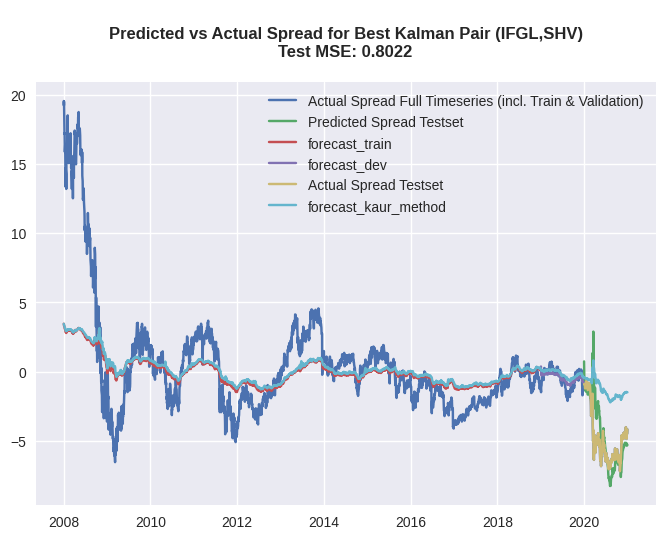

In [ ]:
title = f"""
Predicted vs Actual Spread for Best Kalman Pair (IFGL,SHV)
Test MSE: {output_kalman['test_mse']:.4f}
"""

def _KalmanFilterAverage(x):
  # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01)

  # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

# Kalman filter regression
def _KalmanFilterRegression(x,y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
    initial_state_mean=[0,0],
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=2,
    transition_covariance=trans_cov)

    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means
pairs_timeseries = output_kalman['pairs_timeseries']
state_means = - _KalmanFilterRegression(_KalmanFilterAverage(pairs_timeseries.S1_close),_KalmanFilterAverage(pairs_timeseries.S2_close))[:,0]

results = pairs_timeseries.S1_close + (pairs_timeseries.S2_close * state_means)
forecast_kaur_method = (results - results.mean()) / results.std()



plt.title(title, fontweight='bold')
plt.plot(output_kalman['pairs_timeseries']['Spread_Close'], label="Actual Spread Full Timeseries (incl. Train & Validation)")
plt.plot(output_kalman['forecast_test_shortened_series'], label="Predicted Spread Testset")
plt.plot(output_kalman['forecast_train'], label="forecast_train")
plt.plot(output_kalman['forecast_dev'], label="forecast_dev")
plt.plot(output_kalman['gt_test_shortened_series'], label="Actual Spread Testset")
plt.plot(forecast_kaur_method, label="forecast_kaur_method")
plt.legend()
plt.show()

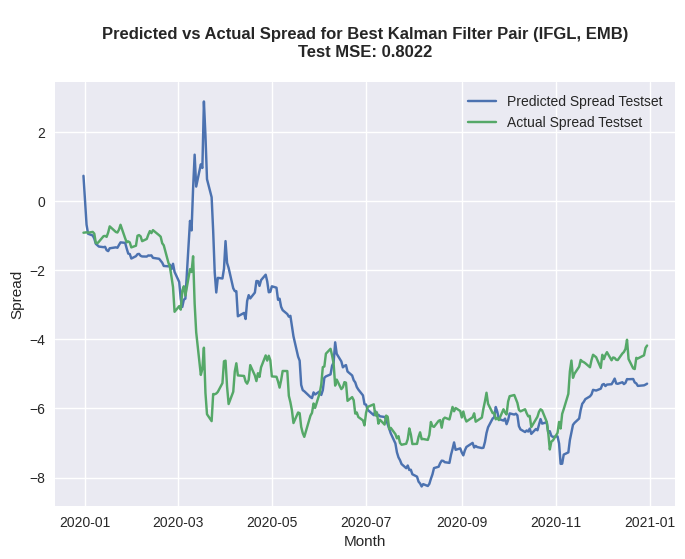

In [ ]:
title = f"""
Predicted vs Actual Spread for Best Kalman Filter Pair (IFGL, EMB)
Test MSE: {output_kalman['test_mse']:.4f}
"""

plt.title(title, fontweight='bold')
plt.plot(output_kalman['forecast_test_shortened_series'], label="Predicted Spread Testset")
plt.plot(output_kalman['gt_test_shortened_series'], label="Actual Spread Testset")
plt.xlabel("Month")
plt.ylabel("Spread")
plt.legend()
plt.show()

In [ ]:
print(results_to_latex(results_kalman_2022))

## Transformer

In [56]:
# Hard code hyperparameters based on results above
hyperparam_kwargs = {'d_model': 256, 'nhead': 8, 'num_layers': 3, 'dropout': 0.1423652841511892, 'learning_rate': 2.4360790710388177e-06, 'min_learning_rate': 8.416991137830168e-05, 'warmup_ratio': 0.01016486209190529, 'weight_decay': 0.27550315286937016, 'batch_size': 64, 'adam_beta1': 0.9595914559778183, 'adam_beta2': 0.9696258195959361, 'adam_epsilon': 5.235073338871379e-10}


### Year-specific data ###
startDateStr = '2008-01-01'
end_year = 2024
endDateStr = f'{end_year}-12-31'
startDateStrTest = f'{end_year}-01-01'
endDateStrTest = f'{end_year}-12-31'
train_frac, dev_frac = _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest)

instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
if pairs_data_filtered is None:
  scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
  pairs_data = {key:value[1]  for (key, value) in pairs.items()}
  pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
  pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
  save_pairs_data_filtered(pairs_data_filtered, startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')

# 2024 8. (IFGL,SMH) 1.64 × 10−3 0.85777 17.19063 15.15% ± 0.46% 26.74% 0.91
wanted_pair = pairs_data_filtered[7][0]
ticker_a, ticker_b = wanted_pair[0], wanted_pair[1]
### Year-specific data ###

### OPTIONAL: define worfklow here for debugging ###

def execute_transformer_workflow(
  pairs_timeseries: pd.DataFrame,
  target_col: str = "Spread_Close",
  col_s1: str = "S1_close",
  col_s2: str = "S2_close",
  train_frac: float = 0.90,
  dev_frac: float = 0.05,   # remaining part is test
  seed: int = 3178749, # for reproducibility, my student number
  look_back: int = 20,
  yearly_trading_days: int = 252,
  ## optimized hyperparams: architecture ##
  d_model: int = 256,
  nhead: int = 8,
  num_layers: int = 4,
  dropout: float = 0.1,
  ## optimized hyperparams: architecture ##
  ## optimized hyperparams: learning algorithm ##
  learning_rate: float = 1e-4,
  min_learning_rate: float = 5e-5,
  warmup_ratio: float = 0.0,
  weight_decay: float = 0.1,
  batch_size: int = 64,
  adam_beta1: float = 0.9,
  adam_beta2: float = 0.95,
  adam_epsilon: float = 1e-8,
  ## optimized hyperparams: learning algorithm ##
  epochs: int = 400,
  patience: int = 150,
  return_datasets: bool = False,
  verbose: bool = False,
  result_parent_dir: str = "data/results",
  filename_base: str = "data_begindate_enddate_hash.pkl",
  pair_tup_str: str = "(?,?)", # Used for showing which tuple was used in plots, example: "(QQQ, SPY)"
):
  # Set seeds
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)

  # For GPU (if used)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)
      torch.cuda.manual_seed_all(seed)
      torch.backends.cudnn.deterministic = True
      torch.backends.cudnn.benchmark = False  # Might slow down, but ensures determinism

  DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
  if verbose:
    print(f"Using device: {DEVICE}")

  if not target_col in pairs_timeseries.columns:
    raise KeyError(f"pairs_timeseries must contain {target_col}")

  total_len = len(pairs_timeseries)
  train_size = int(total_len * train_frac)
  dev_size   = int(total_len * dev_frac)
  test_size  = total_len - train_size - dev_size # not used, but for clarity

  train_univariate = pairs_timeseries[:train_size][[target_col]]
  dev_univariate = pairs_timeseries[train_size:train_size+dev_size][[target_col]] # aka validation
  test_univariate = pairs_timeseries[train_size+dev_size:][[target_col]]

  train_multivariate = pairs_timeseries[:train_size]
  dev_multivariate = pairs_timeseries[train_size:train_size+dev_size] # aka validation
  test_multivariate = pairs_timeseries[train_size+dev_size:]

  if verbose:
      print(f"Split sizes — train: {len(train_univariate)}, dev: {len(dev_univariate)}, test: {len(test_univariate)}")

  def create_sequences_rolling(series, look_back, mean=None, std=None):
      X = []
      y = []
      for i in range(len(series) - look_back):
          seq = series.iloc[i:i+look_back].values
          target = series.iloc[i+look_back]
          X.append(seq)
          y.append(target)

      X = torch.tensor(np.array(X), dtype=torch.float32)
      y = torch.tensor(np.array(y), dtype=torch.float32)

      # z-score normalization
      if mean is None:
        mean = torch.tensor(np.array(series.mean()), dtype=torch.float32)
      if std is None:
        std = torch.tensor(np.array(series.std()), dtype=torch.float32)
      X_scaled = (X - mean) / (std + 1e-8)
      # For y, broadcast mean/std to match shape
      y_scaled = (y - mean) / (std + 1e-8)
      return X, X_scaled, y, y_scaled, mean, std # rolling X (torch tensor), rolling X (torch tensor), torch series, scaled torch series, float, float

  trainX_raw, trainX_scaled, trainY_raw, trainY_scaled, train_mean, train_std = create_sequences_rolling(train_univariate, look_back)
  devX_raw, devX_scaled, devY_raw, devY_scaled, dev_mean, dev_std = create_sequences_rolling(dev_univariate, look_back, train_mean, train_std)
  testX_raw, testX_scaled, testY_raw, testY_scaled, _, _ = create_sequences_rolling(test_univariate, look_back, dev_mean, dev_std)


  # use pytorch Dataset class
  class SlidingWindowDataset(Dataset):
      def __init__(self, X: np.ndarray, y: np.ndarray):
          self.X = X
          self.y = y  # both already casted to torch tensors in create_sequences_rolling

      def __len__(self):
          return self.X.shape[0]

      def __getitem__(self, idx):
          return self.X[idx], self.y[idx]

  train_ds = SlidingWindowDataset(trainX_scaled, trainY_scaled)
  dev_ds   = SlidingWindowDataset(devX_scaled, devY_scaled)
  test_ds  = SlidingWindowDataset(testX_scaled, testY_scaled)

  # extra step after bug: make sure batch_size is int type
  if not isinstance(batch_size, int):
    print(f"Caught bug. batch_size was type {type(batch_size)}")
  batch_size = int(batch_size)
  train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  drop_last=True, num_workers=0) # workers=0 causes it to be processed by main process (cpu)
  dev_loader   = DataLoader(dev_ds, batch_size=batch_size,shuffle=False, drop_last=False, num_workers=0)
  test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=0)

  n_features = trainX_scaled.shape[-1]

  model = TimeSeriesTransformerv1(
              n_features=n_features,
              seq_len=look_back,
              d_model=d_model,
              nhead=nhead,
              num_layers=num_layers,
              dropout=dropout).to(DEVICE)

  criterion = nn.MSELoss()
  optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay, betas=(adam_beta1, adam_beta2), eps=adam_epsilon)
  # learning_rate: float = 1e-4,
  # min_learning_rate: float = 5e-5,
  # warmup_ratio: float = 0.0,
  num_training_steps = len(train_loader) * epochs
  num_warmup_steps = int(warmup_ratio * num_training_steps)
  lr_scheduler = get_cosine_schedule_with_warmup_and_min_lr(
    optimizer=optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
    min_lr=min_learning_rate,
    lr=learning_rate
  )

  EPOCHS = epochs
  PATIENCE = patience

  # implement the early stopping logic manually
  best_val = float("inf")
  epochs_no_improve = 0
  print_per_n = 10

  # save train_loss and val_loss to lists for plotting
  train_losses = []
  val_losses = []

  for epoch in range(1, EPOCHS + 1):
      model.train()
      running_loss = 0.0
      for x_batch, y_batch in train_loader:
          x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
          optimizer.zero_grad()
          preds = model(x_batch).squeeze(-1)
          loss = criterion(preds, y_batch.squeeze(-1))
          loss.backward()
          optimizer.step()
          running_loss += loss.item() * x_batch.size(0)
      train_loss = running_loss / len(train_loader.dataset) # epoch loss = running loss / N samples
      train_losses.append(train_loss)

      model.eval()
      running_loss_val = 0.0
      with torch.no_grad():
          for x_batch, y_batch in dev_loader:
              x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
              preds  = model(x_batch).squeeze(-1)
              running_loss_val += criterion(preds, y_batch.squeeze(-1)).item() * x_batch.size(0)
      val_loss = running_loss_val / len(dev_loader.dataset) # again, epoch loss = running loss / N samples
      val_losses.append(val_loss)

      # update learning rate scheduler
      lr_scheduler.step()

      # print losses in a pretty way
      if epoch % print_per_n == 0:
        print(f"Epoch {epoch:03d} | train MSE {train_loss:.6f} | val MSE {val_loss:.6f}")


      # manual early stopping logic
      if val_loss < best_val - 1e-5: # 1e-5 to not actually make it zero
          best_val = val_loss
          epochs_no_improve = 0
          # model would normally be saved here for later use, but the current worfklow does not do this
          # torch.save(model.state_dict(), "best_transformer.pt")
      else:
          epochs_no_improve += 1
          if epochs_no_improve >= PATIENCE:
              print("Early stopping triggered.")
              break

  # Now, let's evaluate the model on the testset
  # made sure we're in eval mode
  model.eval()

  # Helper: Get preds/targets from dataloader, in scaled space
  def get_preds_targets_scaled(dataloader, model, device):
      all_preds = []
      all_targets = []
      model.eval()
      with torch.no_grad():
          for x_batch, y_batch in dataloader:
              x_batch, y_batch = x_batch.to(device), y_batch.to(device)
              preds = model(x_batch).cpu().numpy()
              targets = y_batch.cpu().numpy()
              all_preds.append(preds)
              all_targets.append(targets)
      all_preds = np.concatenate(all_preds).reshape(-1, 1)
      all_targets = np.concatenate(all_targets).reshape(-1, 1)
      return all_preds, all_targets

  ## GETTING MSE's
  # turn train_std and train_mean into numpy arrays, because torch tensors cannot be used in combination with np
  train_mean, train_std = np.array(train_mean), np.array(train_std)
  dev_mean, dev_std = np.array(dev_mean), np.array(dev_std)
  # VAL (DEV)
  val_preds_scaled, val_targets_scaled = get_preds_targets_scaled(dev_loader, model, DEVICE)
  # Inverse-transform to original space
  val_preds_original_scale = val_preds_scaled * train_std + train_mean
  val_targets_original_scale = val_targets_scaled * train_std + train_mean
  val_mse_after_inverse = mean_squared_error(val_targets_original_scale, val_preds_original_scale)
  val_var = np.var(val_targets_original_scale)
  val_nmse = val_mse_after_inverse / val_var # normalized mean squared error

  # TEST
  test_preds_scaled, test_targets_scaled = get_preds_targets_scaled(test_loader, model, DEVICE)
  test_preds_original_scale = test_preds_scaled * dev_std + dev_mean
  test_targets_original_scale = test_targets_scaled * dev_std + dev_mean
  test_mse_after_inverse = mean_squared_error(test_targets_original_scale, test_preds_original_scale)
  test_var = np.var(test_targets_original_scale)
  test_nmse = test_mse_after_inverse / test_var

  # maybe too much explanation here, but y_hat and y_true respectively represent the predicted and ground truth values
  y_hat = np.concatenate(test_preds_original_scale).reshape(-1, 1)
  y_true = np.concatenate(test_targets_original_scale).reshape(-1, 1)

  ## Trading
  test_s1_shortened = test_multivariate[col_s1].iloc[look_back:]
  test_s2_shortened = test_multivariate[col_s2].iloc[look_back:] # use multivariate versions, so we can still access cols like 'S1_close' and 'S2_close'
  test_index_shortened = test_multivariate.index[look_back:] # officially doesn't really matter whether to use `test_multivariate` or `test`, but do it like this for consistency
  forecast_test_shortened_series = pd.Series(y_hat.squeeze(), index=test_index_shortened)
  gt_test_shortened_series = pd.Series(y_true.squeeze(), index=test_index_shortened)

  dev_index_shortened = dev_multivariate.index[look_back:]
  forecast_dev_shortened_series = pd.Series((val_preds_original_scale).reshape(-1, 1).squeeze(), index=dev_index_shortened)
  gt_dev_shortened_series = pd.Series((val_targets_original_scale).reshape(-1, 1).squeeze(), index=dev_index_shortened)


  output = get_gt_yoy_returns_test_dev(pairs_timeseries, dev_frac, train_frac, look_back=20, yearly_trading_days=yearly_trading_days)
  gt_yoy, gt_yoy_for_dev_dataset = output['gt_yoy_test'], output['gt_yoy_dev']

  ## Trading: Mean YoY
  min_position = 3.00
  max_position = 3.50
  min_clearing = 0.40
  max_clearing = 0.50
  position_thresholds = np.linspace(min_position, max_position, num=10)
  clearing_thresholds = np.linspace(min_clearing, max_clearing, num=10)
  yoy_mean, yoy_std = calculate_return_uncertainty(test_s1_shortened, test_s2_shortened, forecast_test_shortened_series, position_thresholds=position_thresholds, clearing_thresholds=clearing_thresholds)

  ## The variables that should be returned, according to what was returned by the `execute_kalman_workflow` func:
  # give same output as was originally the case
  current_result_dir = filename_base.replace(".pkl", "_transformer")
  result_dir = os.path.join(result_parent_dir, current_result_dir)
  if not os.path.exists(result_dir):
      os.makedirs(result_dir)
  output: Dict[str, Any] = dict(
      val_mse=val_nmse,
      test_mse=test_nmse,
      yoy_mean=yoy_mean,
      yoy_std=yoy_std,
      gt_yoy=gt_yoy,
      result_parent_dir=result_parent_dir,
  )

  results_str = f"""
Validation MSE: {output['val_mse']}
Test MSE: {output['test_mse']}
YOY Returns: {output['yoy_mean'] * 100:.2f}%
YOY Std: +- {output['yoy_std'] * 100:.2f}%
GT Yoy: {output['gt_yoy'] * 100:.2f}%
Plot filepath parent dir: {output['result_parent_dir']}
pair_tup_str: {pair_tup_str}
  """
  with open(os.path.join(result_dir, "results.txt"), "w") as f:
      f.write(results_str)
  if verbose:
    print(results_str)

  if return_datasets:
      output.update(
          dict(
            train_multivariate=train_multivariate,
            pairs_timeseries=pairs_timeseries,
            test_s1_shortened=test_s1_shortened,
            test_s2_shortened=test_s2_shortened,
            gt_dev_shortened_series=gt_dev_shortened_series,
            forecast_dev_shortened_series=forecast_dev_shortened_series,
            forecast_test_shortened_series=forecast_test_shortened_series,
            gt_test_shortened_series=gt_test_shortened_series
          )
      )
  return output

### OPTIONAL: define worfklow here for debugging ###

# Gather results for 2024
pair_tup_str_current = f"({ticker_a},{ticker_b})"
pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
output_returns = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
gt_yoy, gt_yoy_for_dev_dataset = output_returns['gt_yoy_test'], output_returns['gt_yoy_dev']
output_transformer = execute_transformer_workflow(pairs_timeseries_df, verbose=verbose, pair_tup_str=pair_tup_str_current, train_frac=train_frac, dev_frac=dev_frac, return_datasets=return_datasets, epochs=300, **hyperparam_kwargs)
# print(output_transformer
yoy_str = f"{output_transformer['yoy_mean'] * 100:.2f}% +- {output_transformer['yoy_std'] * 100:.2f}%"
returns_score = return_score(output_transformer['yoy_mean'], gt_yoy)

Using device: cuda
Split sizes — train: 3774, dev: 251, test: 252
Epoch 010 | train MSE 0.623117 | val MSE 7.493114
Epoch 020 | train MSE 0.080892 | val MSE 1.863053
Epoch 030 | train MSE 0.037108 | val MSE 0.774596
Epoch 040 | train MSE 0.026710 | val MSE 0.535831
Epoch 050 | train MSE 0.019183 | val MSE 0.343577
Epoch 060 | train MSE 0.015102 | val MSE 0.232754
Epoch 070 | train MSE 0.013370 | val MSE 0.187065
Epoch 080 | train MSE 0.012313 | val MSE 0.145794
Epoch 090 | train MSE 0.011560 | val MSE 0.147977
Epoch 100 | train MSE 0.011197 | val MSE 0.117587
Epoch 110 | train MSE 0.010118 | val MSE 0.118054
Epoch 120 | train MSE 0.009648 | val MSE 0.114325
Epoch 130 | train MSE 0.009642 | val MSE 0.105838
Epoch 140 | train MSE 0.009223 | val MSE 0.089255
Epoch 150 | train MSE 0.008589 | val MSE 0.100844
Epoch 160 | train MSE 0.008525 | val MSE 0.100079
Epoch 170 | train MSE 0.008507 | val MSE 0.078219
Epoch 180 | train MSE 0.011860 | val MSE 0.080610
Epoch 190 | train MSE 0.010793 | v

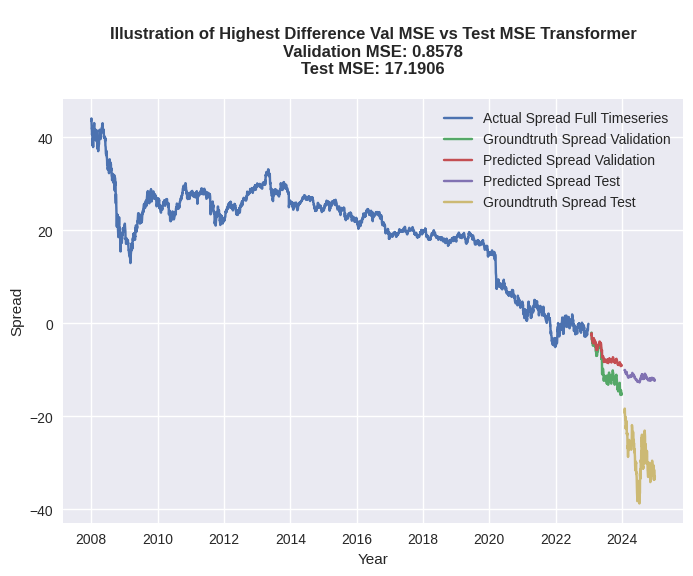

In [66]:
title = f"""
Illustration of Highest Difference Val MSE vs Test MSE Transformer
Validation MSE: {output_transformer['val_mse']:.4f}
Test MSE: {output_transformer['test_mse']:.4f}
"""

train_size = len(output_transformer['train_multivariate'])

plt.title(title, fontweight='bold')
plt.plot(output_transformer['pairs_timeseries']['Spread_Close'][:train_size], label="Actual Spread Full Timeseries")
plt.plot(output_transformer['gt_dev_shortened_series'], label="Groundtruth Spread Validation")
plt.plot(output_transformer['forecast_dev_shortened_series'], label="Predicted Spread Validation")
plt.plot(output_transformer['forecast_test_shortened_series'], label="Predicted Spread Test")
plt.plot(output_transformer['gt_test_shortened_series'], label="Groundtruth Spread Test")
plt.xlabel("Year")
plt.ylabel("Spread")
plt.legend()
plt.show()

## Time-MoE

In [62]:
import json

# Hard code hyperparameters based on results above
hyperparam_kwargs = {'learning_rate': 2.0475604252491958e-05, 'min_learning_rate': 2.6086424722448012e-06, 'warmup_ratio': 0.048810916053081604, 'weight_decay': 0.24532990507861047, 'batch_size': 128, 'adam_beta1': 0.8845073518509828, 'adam_beta2': 0.9823969626258993, 'adam_epsilon': 2.736776387774778e-10}

### Year-specific data ###
startDateStr = '2008-01-01'
end_year = 2020
endDateStr = f'{end_year}-12-31'
startDateStrTest = f'{end_year}-01-01'
endDateStrTest = f'{end_year}-12-31'
train_frac, dev_frac = _get_train_dev_frac(startDateStr, endDateStr, startDateStrTest, endDateStrTest)

instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached_using_truncate(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
if pairs_data_filtered is None:
  scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
  pairs_data = {key:value[1]  for (key, value) in pairs.items()}
  pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
  pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
  save_pairs_data_filtered(pairs_data_filtered, startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')

# 2020 7. (IGSB,BND) 1.56 × 10−3 0.01813 0.29892 0.06% ± 0.12% -0.36% 1.00
wanted_pair = pairs_data_filtered[6][0]
ticker_a, ticker_b = wanted_pair[0], wanted_pair[1]
### Year-specific data ###

### OPTIONAL: define worfklow here for debugging ###

def execute_timemoe_workflow(
  pairs_timeseries: pd.DataFrame,
  target_col: str = "Spread_Close",
  col_s1: str = "S1_close",
  col_s2: str = "S2_close",
  train_frac: float = 0.90,
  dev_frac: float = 0.05,   # remaining part is test
  seed: int = 3178749, # for reproducibility, my student number
  look_back: int = 20,
  yearly_trading_days: int = 252,
  ## optimized hyperparams ##
  learning_rate=1e-4,
  min_learning_rate=5e-5,
  warmup_ratio=0.0,
  weight_decay=0.1,
  global_batch_size=64, # (just the batch size) other option would be micro_batch_size, which sets batch size per device
  adam_beta1=0.9,
  adam_beta2=0.95,
  adam_epsilon=1e-8,
  ## optimized hyperparams
  return_datasets: bool = False,
  batch_size: int = 8, # TODO: go over which batch size should be used where! (training vs test inference)
  verbose: bool = True,
  load_finetuned = True,
  result_parent_dir: str = "data/results",
  filename_base: str = "data_begindate_enddate_hash.pkl",
  pair_tup_str: str = "(?,?)" # Used for showing which tuple was used in plots, example: "(QQQ, SPY)"
):
  # Set seeds
  torch.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)

  # For GPU (if used)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)
      torch.cuda.manual_seed_all(seed)
      torch.backends.cudnn.deterministic = True
      torch.backends.cudnn.benchmark = False  # Might slow down, but ensures determinism

  if not target_col in pairs_timeseries.columns:
    raise KeyError(f"pairs_timeseries must contain {target_col}")

  total_len = len(pairs_timeseries)
  train_size = int(total_len * train_frac)
  dev_size   = int(total_len * dev_frac)
  test_size  = total_len - train_size - dev_size # not used, but for clarity

  pairs_timeseries_univariate = pairs_timeseries[target_col]

  train_univariate = pairs_timeseries_univariate[:train_size]
  dev_univariate = pairs_timeseries_univariate[train_size:train_size+dev_size] # aka validation
  test_univariate = pairs_timeseries_univariate[train_size+dev_size:]

  train_multivariate = pairs_timeseries.iloc[:train_size]
  dev_multivariate = pairs_timeseries.iloc[train_size:train_size+dev_size]
  test_multivariate = pairs_timeseries.iloc[train_size+dev_size:]

  if verbose:
      print(f"Split sizes — train: {len(train_univariate)}, dev: {len(dev_univariate)}, test: {len(test_univariate)}")

  DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
  if verbose:
    print(f"Using device: {DEVICE}")

  def create_sequences(series, mean=None, std=None):
      # series: pd.Series
      X_raw = torch.tensor(series.values, dtype=torch.float32) # note: using .values loses index
      if mean is None:
        # only compute mean if not given
        mean = torch.tensor(np.array(series.mean()), dtype=torch.float32)
      if std is None:
        std = torch.tensor(np.array(series.std()), dtype=torch.float32)
      X_scaled = (X_raw - mean) / (std + 1e-8)
      return X_raw, X_scaled, mean, std

  def create_sequences_rolling(series, look_back, mean=None, std=None):
      X = []
      y = []
      for i in range(len(series) - look_back):
          seq = series.iloc[i:i+look_back].values
          target = series.iloc[i+look_back]
          X.append(seq)
          y.append(target)

      X = torch.tensor(np.array(X), dtype=torch.float32)
      y = torch.tensor(np.array(y), dtype=torch.float32)

      # z-score normalization
      if mean is None:
        mean = torch.tensor(np.array(series.mean()), dtype=torch.float32)
      if std is None:
        std = torch.tensor(np.array(series.std()), dtype=torch.float32)
      X_scaled = (X - mean) / (std + 1e-8)
      # For y, broadcast mean/std to match shape
      y_scaled = (y - mean) / (std + 1e-8)
      return X, X_scaled, y, y_scaled, mean, std # rolling X (torch tensor), rolling X (torch tensor), torch series, scaled torch series, float, float

  train_raw, train_scaled, train_mean, train_std = create_sequences(train_univariate)
  dev_raw, dev_scaled, dev_mean, dev_std = create_sequences(dev_univariate, train_mean, train_std)
  test_raw, test_scaled, _, _ = create_sequences(test_univariate, dev_mean, dev_std)

  ## use rolling sequences not for training, but still for inferencing dev and test ##
  trainX_raw, trainX_scaled, trainY_raw, trainY_scaled, train_mean, train_std = create_sequences_rolling(train_univariate, look_back)
  devX_raw_rolling, devX_scaled_rolling, devY_raw_rolling, devY_scaled_rolling, dev_mean, dev_std = create_sequences_rolling(dev_univariate, look_back, train_mean, train_std)
  testX_raw_rolling, testX_scaled_rolling, testY_raw_rolling, testY_scaled_rolling, _, _ = create_sequences_rolling(test_univariate, look_back, dev_mean, dev_std) # Note: dev_mean and test_mean may never be used; preventing data leakage

  dev_ds_rolling = TensorDataset(devX_scaled_rolling, devY_scaled_rolling) # goal of TensorDataset class: loading and processing dataset lazily
  test_ds_rolling = TensorDataset(testX_scaled_rolling, testY_scaled_rolling)

  batch_size = int(batch_size)
  dev_loader_rolling = DataLoader(dev_ds_rolling, batch_size=batch_size, shuffle=False)
  test_loader_rolling = DataLoader(test_ds_rolling, batch_size=batch_size, shuffle=False)
  ## use rolling sequences not for training, but still for inferencing dev and test ##

  if load_finetuned:
    ## Training (only train in the case where we actually also want to load finetuned :D )
    # save contents of trainX_scaled to jsonl using _get_filename {"sequence": [1.7994326779272853, 2.554412431241829,
    filename_jsonl = filename_base.replace(".pkl", ".jsonl")
    filepath_parent = os.path.join("data", "datasets")
    os.makedirs(filepath_parent, exist_ok=True)
    filepath_jsonl = os.path.join(filepath_parent, filename_jsonl)
    with open(filepath_jsonl, "w") as f: # Train scaled (improves results according to paper, and empirical tests have also shown this)
        json_line = json.dumps({"sequence": train_scaled.tolist()})
        f.write(json_line + "\n")

    train_time_moe(
        data_path=filepath_jsonl,
        dataloader_num_workers=2,
        ## hyperparams ##
        learning_rate=learning_rate,
        min_learning_rate=min_learning_rate,
        warmup_ratio=warmup_ratio,
        weight_decay=weight_decay,
        global_batch_size=global_batch_size, # (just the batch size) other option would be micro_batch_size, which sets batch size per device
        adam_beta1=adam_beta1,
        adam_beta2=adam_beta2,
        adam_epsilon=adam_epsilon
        ## hyperparams ##
    ) # after this, model is saved to logs/time_moe as model.safetensors (400+ MB)
    model_dir = "logs/time_moe"
    config = AutoConfig.from_pretrained(model_dir, trust_remote_code=True)
    model = TimeMoeForPrediction.from_pretrained(model_dir, config=config, torch_dtype=torch.float32)
    model.eval()
  else:
    model = AutoModelForCausalLM.from_pretrained(
        'Maple728/TimeMoE-50M',
        trust_remote_code=True,
    )

  prediction_length = 1

  # forecast in batches from dev dataset
  all_predictions = []
  for i, batch in enumerate(test_loader_rolling):
    inputs = batch[0] # is devX_scaled, for now [1] will return error, later [1] will return devY_scaled :D

    # yvals = batch[1]
    # means = batch[2]
    # stds = batch[3]

    output = model.generate(inputs, max_new_tokens=prediction_length)  # shape is [batch_size, look_back + prediction_length]
    normed_predictions = output[:, -prediction_length:]

    # from returned test_mean and test_std, slice the appropriate slices from the series
    input_size_current = inputs.size()
    batch_size_current = input_size_current[0]

    preds = normed_predictions * dev_std + dev_mean
    all_predictions.append(preds)

  # Concatenate all predictions
  predictions = torch.cat(all_predictions, dim=0)
  predictions = predictions.squeeze(-1)
  predictions = predictions.detach().numpy()

  # Also get dev/val predictions
  dev_predictions = []
  for i, batch in enumerate(dev_loader_rolling):
    inputs = batch[0]

    output = model.generate(inputs, max_new_tokens=prediction_length)  # shape is [batch_size, look_back + prediction_length]
    normed_predictions = output[:, -prediction_length:]
    input_size_current = inputs.size()
    batch_size_current = input_size_current[0]

    preds = normed_predictions * train_std + train_mean
    dev_predictions.append(preds)
  dev_predictions = torch.cat(dev_predictions, dim=0)
  dev_predictions = dev_predictions.squeeze(-1)
  dev_predictions = dev_predictions.detach().numpy()

  ## Trading
  test_s1_shortened = test_multivariate[col_s1].iloc[look_back:]
  test_s2_shortened = test_multivariate[col_s2].iloc[look_back:] # use multivariate versions, so we can still access cols like 'S1_close' and 'S2_close'
  test_index_shortened = test_multivariate.index[look_back:] # officially doesn't really matter whether to use `test_multivariate` or `test`, but do it like this for consistency
  forecast_test_shortened_series = pd.Series(predictions, index=test_index_shortened)
  gt_test_shortened_series = pd.Series(test_raw.numpy()[look_back:], index=test_index_shortened)

  dev_index_shortened = dev_multivariate.index[look_back:]
  forecast_dev_shortened_series = pd.Series(dev_predictions, index=dev_index_shortened)
  gt_dev_shortened_series = pd.Series(dev_raw.numpy()[look_back:], index=dev_index_shortened)

  output = get_gt_yoy_returns_test_dev(pairs_timeseries, dev_frac, train_frac, look_back=20, yearly_trading_days=yearly_trading_days)
  gt_yoy, gt_yoy_for_dev_dataset = output['gt_yoy_test'], output['gt_yoy_dev']

  ## Trading: Mean YoY
  min_position = 2.00
  max_position = 4.00
  min_clearing = 0.30
  max_clearing = 0.70
  position_thresholds = np.linspace(min_position, max_position, num=10)
  clearing_thresholds = np.linspace(min_clearing, max_clearing, num=10)
  yoy_mean, yoy_std = calculate_return_uncertainty(test_s1_shortened, test_s2_shortened, forecast_test_shortened_series, position_thresholds=position_thresholds, clearing_thresholds=clearing_thresholds)

  if load_finetuned:
    current_result_dir = filename_base.replace(".pkl", "_timemoe")
  else:
    current_result_dir = filename_base.replace(".pkl", "_timemoe_only_pretrained")
  result_dir = os.path.join(result_parent_dir, current_result_dir)
  if not os.path.exists(result_dir):
      os.makedirs(result_dir)

  dev_mse = mean_squared_error(dev_raw.numpy()[look_back:], dev_predictions)
  test_mse = mean_squared_error(test_raw.numpy()[look_back:], predictions)
  dev_variance = dev_raw.numpy()[look_back:].var()
  dev_nmse = dev_mse / dev_variance if dev_variance != 0 else float('inf')
  test_variance = test_raw.numpy()[look_back:].var()
  test_nmse = test_mse / test_variance if test_variance != 0 else float('inf')

  output: Dict[str, Any] = dict(
      val_mse=dev_nmse,
      test_mse=test_nmse,
      yoy_mean=yoy_mean,
      yoy_std=yoy_std,
      gt_yoy=gt_yoy,
      result_parent_dir=result_parent_dir,
  )

  results_str = f"""
Validation MSE: {output['val_mse']}
Test MSE: {output['test_mse']}
YOY Returns: {output['yoy_mean'] * 100:.2f}%
YOY Std: +- {output['yoy_std'] * 100:.2f}%
GT Yoy: {output['gt_yoy'] * 100:.2f}%
Plot filepath parent dir: {output['result_parent_dir']}
pair_tup_str: {pair_tup_str}
  """

  with open(os.path.join(result_dir, "results.txt"), "w") as f:
      f.write(results_str)
  if verbose:
    print(results_str)
  if return_datasets:
      output.update(
          dict(
            train_multivariate=train_multivariate,
            pairs_timeseries=pairs_timeseries,
            test_s1_shortened=test_s1_shortened,
            test_s2_shortened=test_s2_shortened,
            gt_dev_shortened_series=gt_dev_shortened_series,
            forecast_dev_shortened_series=forecast_dev_shortened_series,
            forecast_test_shortened_series=forecast_test_shortened_series,
            gt_test_shortened_series=gt_test_shortened_series
          )
      )
  return output

### OPTIONAL: define worfklow here for debugging ###

# Gather results for ..
pair_tup_str_current = f"({ticker_a},{ticker_b})"
pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
output_returns = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
gt_yoy, gt_yoy_for_dev_dataset = output_returns['gt_yoy_test'], output_returns['gt_yoy_dev']
output_timemoe = execute_timemoe_workflow(pairs_timeseries_df, verbose=verbose, pair_tup_str=pair_tup_str_current, train_frac=train_frac, dev_frac=dev_frac, return_datasets=return_datasets, **hyperparam_kwargs)
# print(output_timemoe
yoy_str = f"{output_timemoe['yoy_mean'] * 100:.2f}% +- {output_timemoe['yoy_std'] * 100:.2f}%"
returns_score = return_score(output_timemoe['yoy_mean'], gt_yoy)

Split sizes — train: 2769, dev: 251, test: 253
Using device: cuda
2025-06-18 12:20:47,759 - log_util.py[pid:1429;line:48:log_in_local_rank_0] - WARNING: Flash attention import failed, switching to eager attention.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 2033.11it/s]


Step,Training Loss
1,0.031400


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(



Validation MSE: 0.01812939600433806
Test MSE: 0.2989169103877188
YOY Returns: 0.06%
YOY Std: +- 0.12%
GT Yoy: -0.36%
Plot filepath parent dir: data/results
pair_tup_str: (IGSB,BND)
  


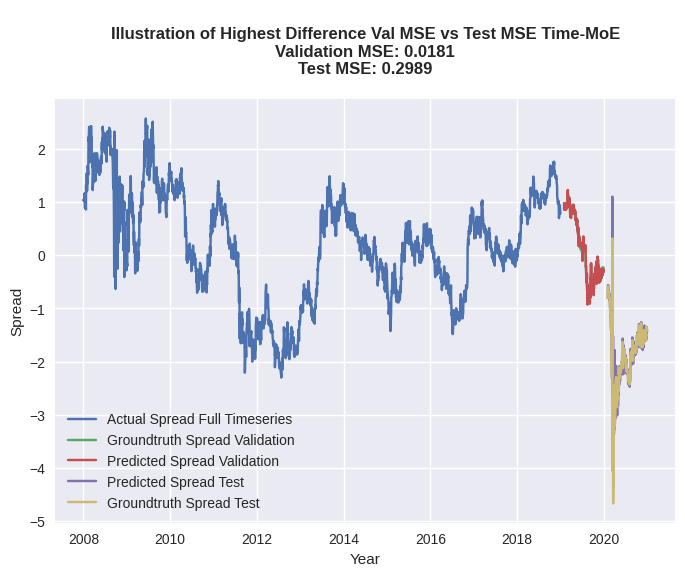

In [67]:
title = f"""
Illustration of Highest Difference Val MSE vs Test MSE Time-MoE
Validation MSE: {output_timemoe['val_mse']:.4f}
Test MSE: {output_timemoe['test_mse']:.4f}
"""

train_size = len(output_timemoe['train_multivariate'])

plt.title(title, fontweight='bold')
plt.plot(output_timemoe['pairs_timeseries']['Spread_Close'][:train_size], label="Actual Spread Full Timeseries")
plt.plot(output_timemoe['gt_dev_shortened_series'], label="Groundtruth Spread Validation")
plt.plot(output_timemoe['forecast_dev_shortened_series'], label="Predicted Spread Validation")
plt.plot(output_timemoe['forecast_test_shortened_series'], label="Predicted Spread Test")
plt.plot(output_timemoe['gt_test_shortened_series'], label="Groundtruth Spread Test")
plt.xlabel("Year")
plt.ylabel("Spread")
plt.legend()
plt.show()

In [40]:
pairs_timeseries = output_timemoe['pairs_timeseries']

output = get_gt_yoy_returns_test_dev(pairs_timeseries, dev_frac, train_frac, look_back=20)
gt_yoy, gt_yoy_for_dev_dataset = output['gt_yoy_test'], output['gt_yoy_dev']

test_s1_shortened = output_timemoe['test_s1_shortened']
test_s2_shortened = output_timemoe['test_s2_shortened']
forecast_test_shortened_series = output_timemoe['forecast_test_shortened_series']
gt_test_shortened_series = output_timemoe['gt_test_shortened_series']

min_position = 2.00
max_position = 4.00
min_clearing = 0.30
max_clearing = 0.70
position_thresholds = np.linspace(min_position, max_position, num=10)
clearing_thresholds = np.linspace(min_clearing, max_clearing, num=10)


yoy_mean, yoy_std = calculate_return_uncertainty(test_s1_shortened, test_s2_shortened, forecast_test_shortened_series, position_thresholds=position_thresholds, clearing_thresholds=clearing_thresholds)
gt_yoy_using_timemoe, gt_yoy_std_using_timemoe = calculate_return_uncertainty(test_s1_shortened, test_s2_shortened, gt_test_shortened_series, position_thresholds=position_thresholds, clearing_thresholds=clearing_thresholds)

-0.06500046790072878
0.059330522929453844
-0.026628980051673246
0.035641718443454096
0.020943808356151727
-0.0885057614845568


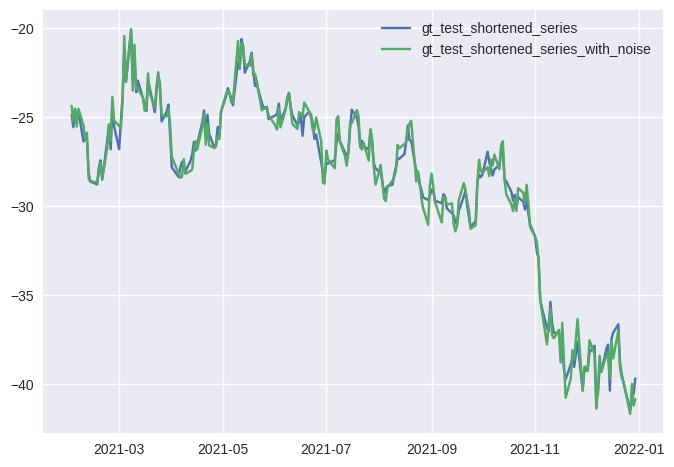

In [51]:
# add artificial noise to gt_yoy
gt_test_shortened_series_with_noise = gt_test_shortened_series + np.random.normal(0, 0.5, len(gt_test_shortened_series))
plt.plot(gt_test_shortened_series, label="gt_test_shortened_series")
plt.plot(gt_test_shortened_series_with_noise, label="gt_test_shortened_series_with_noise")
plt.legend()

for noise in [0, 0.5, 1.0, 2.0, 3.0, 4.0]:
  yoy_mean, yoy_std = calculate_return_uncertainty(test_s1_shortened, test_s2_shortened, gt_test_shortened_series + np.random.normal(0, noise, len(gt_test_shortened_series)), position_thresholds=position_thresholds, clearing_thresholds=clearing_thresholds)
  print(yoy_mean)

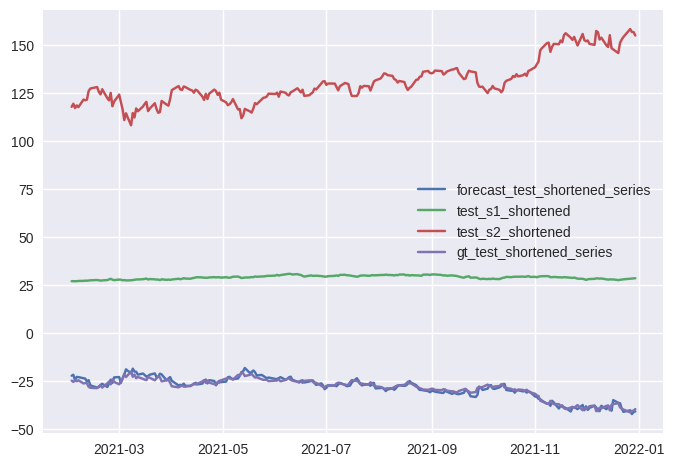

In [35]:
plt.plot(forecast_test_shortened_series, label='forecast_test_shortened_series')
plt.plot(test_s1_shortened, label='test_s1_shortened')
plt.plot(test_s2_shortened, label='test_s2_shortened')
plt.plot(gt_test_shortened_series, label='gt_test_shortened_series')
plt.legend()